### Unzip the dataset

In [1]:
! unzip /content/dataset.zip

Archive:  /content/dataset.zip
  inflating: imbalanced_data.csv     
  inflating: raw_data.csv            


### Import the modules

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import pickle

In [3]:
from nltk.tokenize import word_tokenize
import re
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import string

In [4]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import tensorflow
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [6]:
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dropout,Dense,SpatialDropout1D
from keras.optimizers import RMSprop
from keras.models import load_model

In [7]:
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### Data Preparation

In [8]:
imbalanced_data = pd.read_csv("imbalanced_data.csv")

In [9]:
imbalanced_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [10]:
imbalanced_data = imbalanced_data[["label","tweet"]]

In [11]:
imbalanced_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [12]:
imbalanced_data.shape

(31962, 2)

In [13]:
imbalanced_data.isna().sum()

label    0
tweet    0
dtype: int64

In [14]:
imbalanced_data["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

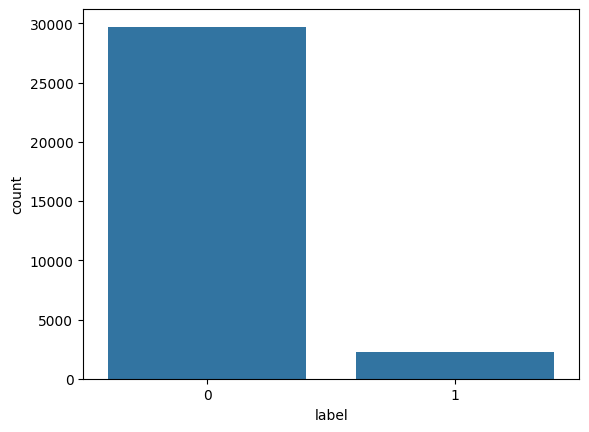

In [15]:
sns.countplot(x="label",data=imbalanced_data)

`Conclusion:`

***0 ---> not hate speech***

***1 ---> hate speech***

In [16]:
raw_data = pd.read_csv("raw_data.csv")

In [17]:
raw_data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [18]:
raw_data = raw_data[["class","tweet"]]

In [19]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [20]:
raw_data.shape

(24783, 2)

In [21]:
raw_data.isna().sum()

class    0
tweet    0
dtype: int64

In [22]:
raw_data["class"].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

<Axes: xlabel='class', ylabel='count'>

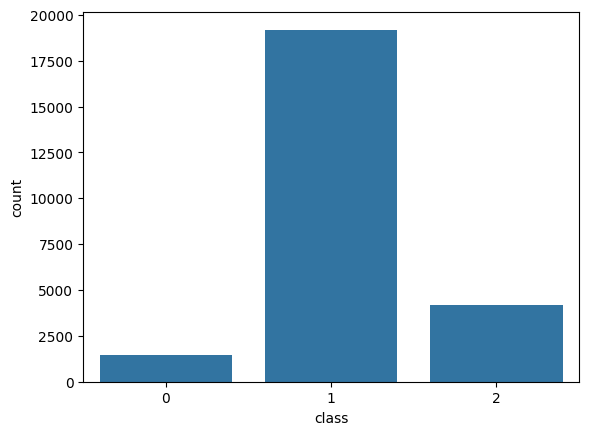

In [23]:
sns.countplot(x="class",data=raw_data)

`Conclusion:`

***class 0 - hate***

***class 1 - abusive***

***class 2 - no hate***

`Note:` Here we can merge both hate and abusive speech

In [24]:
raw_data["class"] = raw_data["class"].replace(0,1)

In [25]:
raw_data["class"].value_counts()

1    20620
2     4163
Name: class, dtype: int64

In [26]:
raw_data["class"] = raw_data["class"].replace(2,0)

In [27]:
raw_data["class"].value_counts()

1    20620
0     4163
Name: class, dtype: int64

In [28]:
raw_data.rename(columns={"class":"label"},inplace=True)

In [29]:
raw_data.head()

,label,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [30]:
imbalanced_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [31]:
# Merging both the dataset
df = pd.concat([imbalanced_data,raw_data])

In [32]:
df.shape

(56745, 2)

In [33]:
df["label"].value_counts()

0    33883
1    22862
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

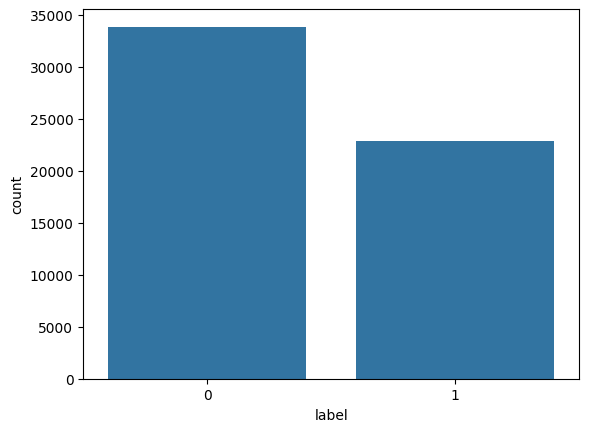

In [34]:
sns.countplot(x="label",data=df)

### Preprocessing

In [35]:
ss = SnowballStemmer(language="english")

contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and "}

def contr_to_exp(x):
    if type(x) is str:
        for key in contractions.keys():
            value = contractions[key]
            x = x.replace(key,value)
        return x
    else:
        return x

# Perform data cleaning
def data_cleaning(words):
  # Apply lowercase
  words = words.lower()
  # Removing URL
  words = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '',words)
  # Removing HTML tags
  pattern = re.compile(r'<.*?>')
  words = re.sub(pattern, '', words)
  # Removing email
  words = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', "",words)
  # Removing punctuations
  words = words.translate(str.maketrans('', '', string.punctuation))
  # Removing multiple spaces
  words = " ".join(words.split())

  # Contraction to Expansion
  words = contr_to_exp(words)

  # Removing RT
  words = re.sub("rt","",words)

  # word tokenize
  word_tokenized_text = word_tokenize(words)
  # Applying stemming as well as removing stopwords
  return " ".join([ss.stem(word) for word in word_tokenized_text if word not in stopwords.words("english")])

In [36]:
df["tweet"][1]

1    @user @user thanks for #lyft credit i can't us...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
Name: tweet, dtype: object

In [37]:
df["tweet"] = df["tweet"].apply(data_cleaning)

In [38]:
df["tweet"][1]

1    user user thank lyft credit cant use caus dont...
1    mleew17 boy dat coldtyga dwn bad cuffin dat ho...
Name: tweet, dtype: object

### EDA

In [39]:
wc = WordCloud(width = 500,height=500,min_font_size=10)

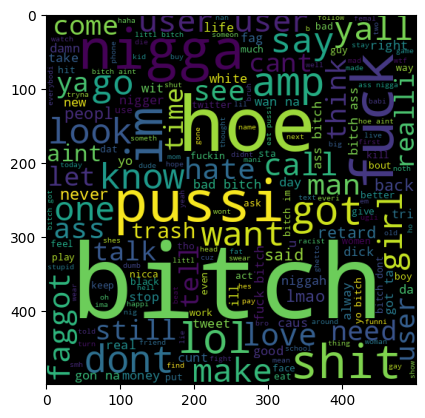

In [40]:
hate_wc = wc.generate(df[df["label"] == 1]["tweet"].str.cat(sep=" "))
plt.imshow(hate_wc)

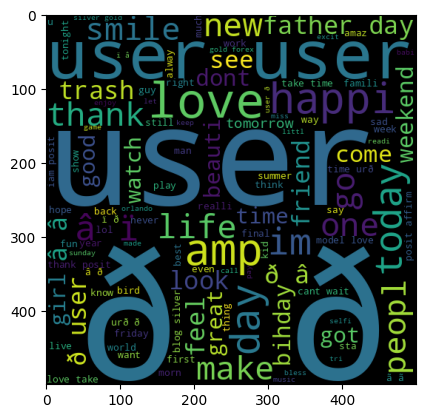

In [41]:
not_hate_wc = wc.generate(df[df["label"] == 0]["tweet"].str.cat(sep=" "))
plt.imshow(not_hate_wc)

### Split into Dependent & Independent Features

In [42]:
X = df["tweet"]
y = df["label"]

### Train, Test & Split

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Feature Engineering

In [45]:
max_words = 50000 # vocabulary
max_len = 300 # length of tweet

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

sequences = tokenizer.texts_to_sequences(X_train)
sequence_matrix = pad_sequences(sequences,maxlen=max_len)

### Model Building

In [46]:
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation="sigmoid"))

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 300, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5080501 (19.38 MB)
Trainable params: 5080501 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compiling the model

In [48]:
model.compile(loss="binary_crossentropy",optimizer=RMSprop(),metrics="accuracy")

### Training the model

In [49]:
history = model.fit(sequence_matrix,y_train,batch_size=128,epochs=1,validation_split=0.2)

284/284 [==============================] - 426s 1s/step - loss: 0.2974 - accuracy: 0.8775 - val_loss: 0.1789 - val_accuracy: 0.9403


### Evaluation the model

In [50]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [51]:
test_sequences_matrix

array([[    0,     0,     0, ...,  1514,     2,  3005],
       [    0,     0,     0, ...,  2664, 17363,  7429],
       [    0,     0,     0, ...,   196,   218,  1002],
       ...,
       [    0,     0,     0, ..., 16681,   824, 46482],
       [    0,     0,     0, ...,   206,   207,   204],
       [    0,     0,     0, ...,   218,   106,  2883]], dtype=int32)

In [52]:
model.evaluate(test_sequences_matrix,y_test)

355/355 [==============================] - 38s 107ms/step - loss: 0.2012 - accuracy: 0.9301


[0.20121799409389496, 0.9301260113716125]

In [53]:
lstm_prediction = model.predict(test_sequences_matrix)

355/355 [==============================] - 37s 105ms/step


In [54]:
lstm_prediction

array([[0.99842983],
       [0.00541097],
       [0.90775007],
       ...,
       [0.35189173],
       [0.00103282],
       [0.9960731 ]], dtype=float32)

In [55]:
y_pred = np.where(lstm_prediction>=0.5,1,0)
y_pred

array([[1],
       [0],
       [1],
       ...,
       [0],
       [0],
       [1]])

### Metrics

In [56]:
confusion_matrix(y_test,y_pred)

array([[6631,  105],
       [ 688, 3925]])

### Saving the model & tokenizer

In [57]:
with open("tokenizer.pkl","wb") as handle:
  pickle.dump(tokenizer,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Prediction on user data

In [59]:
load_model = load_model("model.h5")

with open("tokenizer.pkl","rb") as handle:
  load_token = pickle.load(handle)

In [60]:
# Perform data cleaning
def clean_data(words):
  # Apply lowercase
  words = words.lower()
  # Removing URL
  words = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '',words)
  # Removing HTML tags
  pattern = re.compile(r'<.*?>')
  words = re.sub(pattern, '', words)
  # Removing email
  words = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', "",words)
  # Removing punctuations
  words = words.translate(str.maketrans('', '', string.punctuation))
  # Removing multiple spaces
  words = " ".join(words.split())

  # Contraction to Expansion
  words = contr_to_exp(words)

  # Removing RT
  words = re.sub("rt","",words)

  # word tokenize
  word_tokenized_text = word_tokenize(words)
  # Applying stemming as well as removing stopwords
  return " ".join([ss.stem(word) for word in word_tokenized_text if word not in stopwords.words("english")])

In [61]:
test = "i love this movie"


test = [clean_data(test)]
print(test)

seq = load_token.texts_to_sequences(test)
padded = pad_sequences(seq,maxlen=300)
print(seq)

pred = load_model.predict(padded)

pred = np.where(pred>=0.5,"hate","loved")
pred

['love movi']
[[5, 375]]
1/1 [==============================] - 0s 334ms/step


array([['loved']], dtype='<U5')